In [1]:
import math
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
import pandas as pd
import time

import pickle

In [2]:
class CIFAR10Corrupted(CIFAR10):
    def __init__(self, corrupt_prob, num_classes=10, **kwargs):
        super().__init__(**kwargs)
        if corrupt_prob > 0:
            self.n_classes = num_classes
            self.corrupt_labels(corrupt_prob)

    def corrupt_labels(self, corrupt_prob):
        labels = np.array(self.targets)
        np.random.seed(42)
        mask = np.random.rand(len(labels)) <= corrupt_prob
        rnd_labels = np.random.choice(self.n_classes, mask.sum())
        labels[mask] = rnd_labels
        labels = [int(x) for x in labels]
        self.targets = labels

In [3]:
def get_cifar_dataloaders_corrupted(corrupt_prob=0, batch_size=32):
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = CIFAR10Corrupted(root='./CIFAR', train=True, download=True, transform=transform, corrupt_prob=corrupt_prob)
    train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
    testset = CIFAR10Corrupted(root='./CIFAR', train=False, download=True, transform=transform, corrupt_prob=corrupt_prob)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader



In [4]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                                padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                                padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
            out = self.conv1(x)
        else:
            out = self.conv1(self.relu1(self.bn1(x)))

        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(self.relu2(self.bn2(out)))
        if not self.equalInOut:
            return torch.add(self.convShortcut(x), out)
        else:
            return torch.add(x, out)


class NetworkBlock(nn.Module):
        def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
            super(NetworkBlock, self).__init__()
            self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)

        def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
            layers = []
            for i in range(nb_layers):
                layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
            return nn.Sequential(*layers)

        def forward(self, x):
            return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth=28, num_classes=10, widen_factor=1, drop_rate=0.0, init_scale=1.0):
        super(WideResNet, self).__init__()

        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) // 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                                padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(
            n, nChannels[0], nChannels[1], block, 1, drop_rate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, drop_rate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, drop_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, init_scale * math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

                size = m.weight.size()
                fan_out = size[0] # number of rows
                fan_in = size[1] # number of columns
                variance = math.sqrt(2.0/(fan_in + fan_out))
                m.weight.data.normal_(0.0, init_scale * variance)


    def forward(self, x):
        out = self.forward_repr(x)
        return self.fc(out)

    def forward_repr(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return out

In [5]:
def run_train_single_epoch(train_loader, model, device, criterion, optimizer):
    running_loss = 0.0
    num_correct = 0
    for batch_num, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*len(inputs)
        if batch_num%200==0:
            print("Batch {} Loss: {}".format(batch_num, loss.item()))
        preds = outputs.argmax(1)
        num_correct += (preds==labels).sum().item()
    epoch_loss = running_loss/len(train_loader.sampler)
    epoch_acc = num_correct/len(train_loader.sampler)
    return epoch_loss, epoch_acc

def run_validation_single_epoch(valid_loader, model, device, criterion):
    running_loss = 0.0
    num_correct = 0
    for batch_num, data in enumerate(valid_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()*len(inputs)
        preds = outputs.argmax(1)
        num_correct += (preds==labels).sum().item()
    epoch_loss = running_loss/len(valid_loader.sampler)
    epoch_acc = num_correct/len(valid_loader.sampler)
    return epoch_loss, epoch_acc

def training_loop(model, num_epochs, train_loader, valid_loader, device, \
                  criterion, optimizer, model_name):
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    highest_acc = 1e-10
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = run_train_single_epoch(train_loader, model, device, criterion, optimizer)
        model.eval()
        valid_loss, valid_acc = run_validation_single_epoch(valid_loader, model, device, criterion)
        print("[Epoch {}] Train Loss: {} Vaidation Loss: {} Train Acc: {} Validation Acc: {}".format(\
              epoch, train_loss, valid_loss, train_acc, valid_acc))
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        if valid_acc > highest_acc:
            torch.save(model.state_dict(), "{}.pth".format(model_name))
            highest_acc = valid_acc
    print('Finished Training')
    return train_losses, valid_losses, train_accs, valid_accs

def run_testing(test_loader, model, device):
    model.eval()
    gt_all, preds_all = [], []
    for batch_num, data in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        gt_all.extend(labels.tolist())
        preds_all.extend(preds.tolist())
    return gt_all, preds_all
    

In [6]:
def plot_losses(training_loss_arr, validation_loss_arr, training_acc_arr, validation_acc_arr, \
                title):
    num_epochs = len(training_loss_arr)
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_loss_arr, '-bo', label="Training Loss")
    ax.plot(range(num_epochs), validation_loss_arr, '-ro', label="Validation Loss")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    plt.subplot(1,2,2)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_acc_arr, '-bo', label="Training Acc")
    ax.plot(range(num_epochs), validation_acc_arr, '-ro', label="Validation Acc")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)    

In [7]:
final_dict = dict()

In [8]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



Extracting ./CIFAR/cifar-10-python.tar.gz to ./CIFAR
Files already downloaded and verified
cuda:0


In [9]:
model = WideResNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [10]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 20, train_loader, test_loader,
                                          device, criterion, optimizer, "WideResNet_corr_0")

Batch 0 Loss: 2.337498664855957
Batch 200 Loss: 2.0058460235595703
Batch 400 Loss: 1.8910375833511353
Batch 600 Loss: 2.186770439147949
Batch 800 Loss: 1.562384843826294
Batch 1000 Loss: 1.721944808959961
Batch 1200 Loss: 1.8624076843261719
Batch 1400 Loss: 1.7211198806762695
[Epoch 0] Train Loss: 1.8283843942260742 Vaidation Loss: 1.6194801570892334 Train Acc: 0.3109 Validation Acc: 0.4022
Batch 0 Loss: 1.659466028213501
Batch 200 Loss: 1.7749823331832886
Batch 400 Loss: 1.5277460813522339
Batch 600 Loss: 1.6691679954528809
Batch 800 Loss: 1.4535441398620605
Batch 1000 Loss: 1.2578448057174683
Batch 1200 Loss: 1.274122714996338
Batch 1400 Loss: 1.1940473318099976
[Epoch 1] Train Loss: 1.5315416903305055 Vaidation Loss: 1.4212752437591554 Train Acc: 0.43532 Validation Acc: 0.4813
Batch 0 Loss: 1.4164342880249023
Batch 200 Loss: 1.4888368844985962
Batch 400 Loss: 1.6750929355621338
Batch 600 Loss: 1.1392557621002197
Batch 800 Loss: 1.251435399055481
Batch 1000 Loss: 1.6396524906158447
B

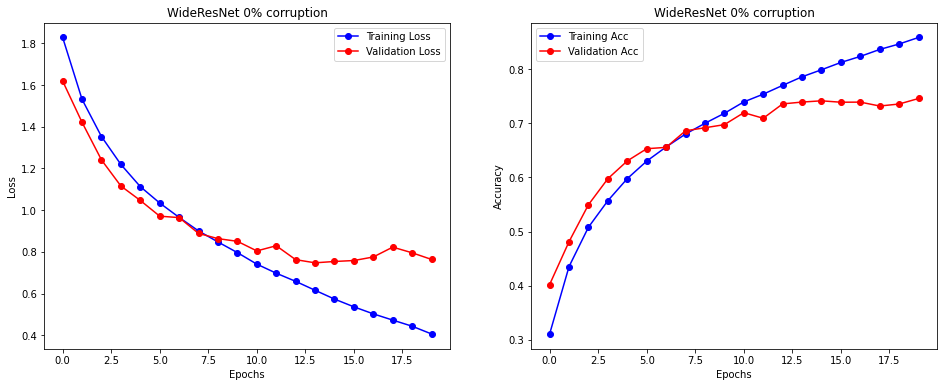

In [11]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "WideResNet 0% corruption")

In [12]:
model = WideResNet()
sd = torch.load("WideResNet_corr_0.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.7455
Confusion Matrix:
 [[802  14  41  20  10   0   9   4  69  31]
 [ 12 852   6  10   2   4   5   1  34  74]
 [ 82   3 615  54 116  32  58  16  18   6]
 [ 16   3  78 628  79  90  61   8  29   8]
 [ 21   1  71  52 773  17  31  19  14   1]
 [ 12   1  63 216  71 567  20  35  10   5]
 [  7   4  55  53  59  13 797   0  10   2]
 [ 23   2  53  45 130  35   5 680   7  20]
 [ 57  13  11  13   6   1   2   0 881  16]
 [ 28  53   6  10   8   1   4   1  29 860]]


In [13]:
final_dict[0] = {}
final_dict[0]["train_losses"] = train_losses
final_dict[0]["valid_losses"] = valid_losses
final_dict[0]["train_accs"] = train_accs
final_dict[0]["validation_accs"] = validation_accs
final_dict[0]["best_test_acc"] = accuracy_score(testy, pred)


In [14]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.2)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [15]:
model = WideResNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [16]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 20, train_loader, test_loader,
                                          device, criterion, optimizer, "WideResNet_corr_20")

Batch 0 Loss: 2.38791561126709
Batch 200 Loss: 2.2267348766326904
Batch 400 Loss: 2.235196590423584
Batch 600 Loss: 2.0153257846832275
Batch 800 Loss: 1.7817672491073608
Batch 1000 Loss: 2.021921396255493
Batch 1200 Loss: 2.0341742038726807
Batch 1400 Loss: 1.7957864999771118
[Epoch 0] Train Loss: 2.0487940308380126 Vaidation Loss: 1.9156824401855468 Train Acc: 0.25692 Validation Acc: 0.3169
Batch 0 Loss: 1.8895601034164429
Batch 200 Loss: 2.098494291305542
Batch 400 Loss: 2.07698392868042
Batch 600 Loss: 1.8325347900390625
Batch 800 Loss: 2.1745967864990234
Batch 1000 Loss: 1.8339595794677734
Batch 1200 Loss: 1.962721586227417
Batch 1400 Loss: 1.7805895805358887
[Epoch 1] Train Loss: 1.8767218566131592 Vaidation Loss: 1.8130990114212036 Train Acc: 0.34458 Validation Acc: 0.3745
Batch 0 Loss: 1.6275197267532349
Batch 200 Loss: 1.9195656776428223
Batch 400 Loss: 2.0529463291168213
Batch 600 Loss: 1.6829544305801392
Batch 800 Loss: 1.9740087985992432
Batch 1000 Loss: 1.8764619827270508
B

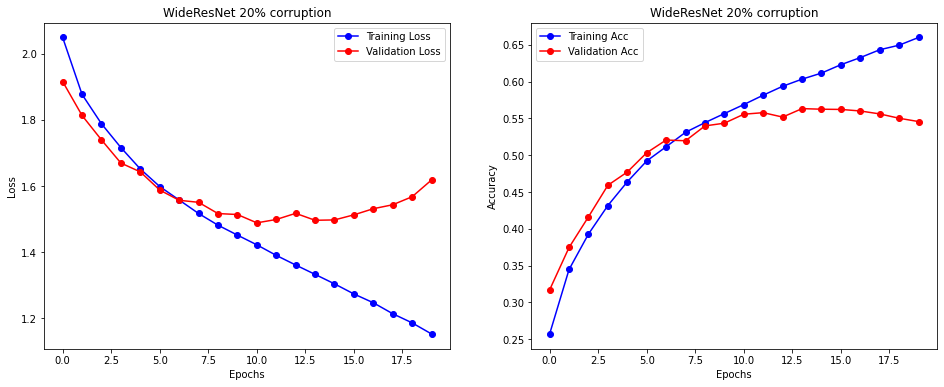

In [17]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "WideResNet 20% corruption")

In [18]:
model = WideResNet()
sd = torch.load("WideResNet_corr_20.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.5633
Confusion Matrix:
 [[587  40  57  37  22  43  37  30 115  28]
 [ 39 668  18  27  17  33  35  17  71  75]
 [ 83  33 432  86  65  90 117  19  26  38]
 [ 45  36  59 429  40 221  98  23  40  42]
 [ 44  29  96  86 459  65 102  48  26  31]
 [ 26  28  51 140  47 566  61  29  22  20]
 [ 20  25  51  92  33  48 670  17  39  23]
 [ 33  29  51  56 107 136  35 460  24  40]
 [ 78  29  34  39  16  35  25  11 701  29]
 [ 39  88  21  24  22  31  34  22  78 661]]


In [19]:
final_dict[20] = {}
final_dict[20]["train_losses"] = train_losses
final_dict[20]["valid_losses"] = valid_losses
final_dict[20]["train_accs"] = train_accs
final_dict[20]["validation_accs"] = validation_accs
final_dict[20]["best_test_acc"]  = accuracy_score(testy, pred)


In [20]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.4)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [21]:
model = WideResNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [22]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 20, train_loader, test_loader,
                                          device, criterion, optimizer, "WideResNet_corr_40")

Batch 0 Loss: 2.306528329849243
Batch 200 Loss: 2.230705976486206
Batch 400 Loss: 2.2018189430236816
Batch 600 Loss: 2.145226001739502
Batch 800 Loss: 2.168930768966675
Batch 1000 Loss: 2.1026499271392822
Batch 1200 Loss: 2.0859858989715576
Batch 1400 Loss: 2.0497334003448486
[Epoch 0] Train Loss: 2.1689739895629883 Vaidation Loss: 2.1079050662994385 Train Acc: 0.21242 Validation Acc: 0.2613
Batch 0 Loss: 2.256321668624878
Batch 200 Loss: 2.075582504272461
Batch 400 Loss: 2.1510114669799805
Batch 600 Loss: 2.1063802242279053
Batch 800 Loss: 2.2006406784057617
Batch 1000 Loss: 2.067382574081421
Batch 1200 Loss: 1.8969221115112305
Batch 1400 Loss: 1.9706084728240967
[Epoch 1] Train Loss: 2.093332412033081 Vaidation Loss: 2.068280894470215 Train Acc: 0.26642 Validation Acc: 0.2886
Batch 0 Loss: 2.0729384422302246
Batch 200 Loss: 2.1233673095703125
Batch 400 Loss: 2.126185417175293
Batch 600 Loss: 2.045367956161499
Batch 800 Loss: 1.9755363464355469
Batch 1000 Loss: 1.9689656496047974
Batc

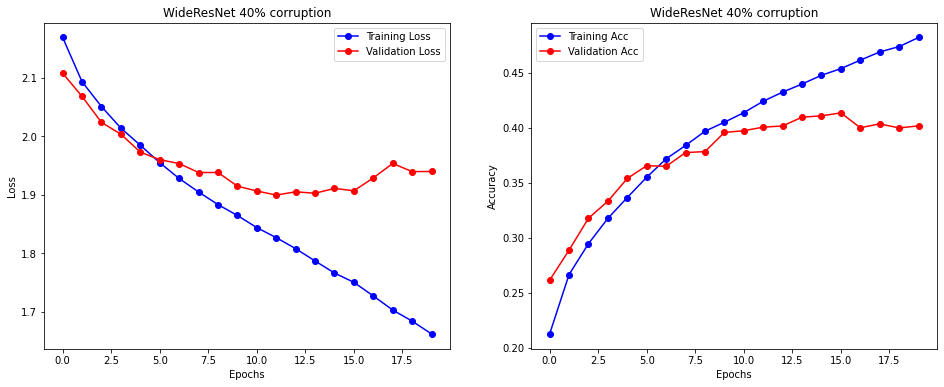

In [23]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "WideResNet 40% corruption")

In [24]:
model = WideResNet()
sd = torch.load("WideResNet_corr_40.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.4134
Confusion Matrix:
 [[406  78  83  75  52  22  54  63 130  57]
 [ 50 557  44  52  42  27  44  47  71  75]
 [102  69 312 106  91  45  95  82  51  41]
 [ 69  73  69 393  82  82  84  82  49  50]
 [ 70  53  87  99 348  29  96 122  52  35]
 [ 48  47  73 240  75 215  70 120  54  39]
 [ 39  48  51 115  74  29 504  66  45  41]
 [ 51  56  46  87  73  56  56 462  41  57]
 [ 84  68  39  66  35  17  46  56 499  61]
 [ 53 136  39  79  42  21  38  82  76 438]]


In [25]:
final_dict[40] = {}
final_dict[40]["train_losses"] = train_losses
final_dict[40]["valid_losses"] = valid_losses
final_dict[40]["train_accs"] = train_accs
final_dict[40]["validation_accs"] = validation_accs
final_dict[40]["best_test_acc"]  = accuracy_score(testy, pred)


In [26]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.6)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [27]:
model = WideResNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [28]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 20, train_loader, test_loader,
                                          device, criterion, optimizer, "WideResNet_corr_60")

Batch 0 Loss: 2.32782244682312
Batch 200 Loss: 2.2399449348449707
Batch 400 Loss: 2.190697431564331
Batch 600 Loss: 2.250093698501587
Batch 800 Loss: 2.2889068126678467
Batch 1000 Loss: 2.2780556678771973
Batch 1200 Loss: 2.353623628616333
Batch 1400 Loss: 2.236191749572754
[Epoch 0] Train Loss: 2.260013254470825 Vaidation Loss: 2.241213949584961 Train Acc: 0.15902 Validation Acc: 0.1879
Batch 0 Loss: 2.1829593181610107
Batch 200 Loss: 2.1719322204589844
Batch 400 Loss: 2.1276867389678955
Batch 600 Loss: 2.2426843643188477
Batch 800 Loss: 2.1538586616516113
Batch 1000 Loss: 2.1222336292266846
Batch 1200 Loss: 2.367788791656494
Batch 1400 Loss: 2.2583625316619873
[Epoch 1] Train Loss: 2.2248620748138426 Vaidation Loss: 2.221657687759399 Train Acc: 0.19388 Validation Acc: 0.2081
Batch 0 Loss: 2.1843271255493164
Batch 200 Loss: 2.19856595993042
Batch 400 Loss: 2.221428394317627
Batch 600 Loss: 2.1560444831848145
Batch 800 Loss: 2.227993965148926
Batch 1000 Loss: 2.251986026763916
Batch 12

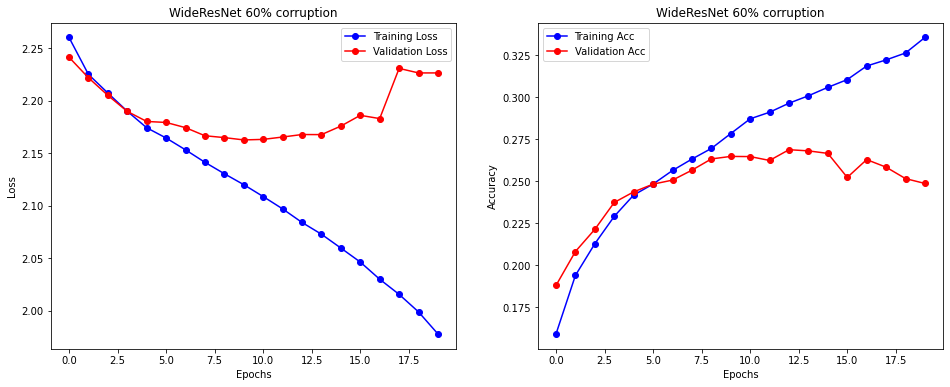

In [29]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "WideResNet 60% corruption")

In [30]:
model = WideResNet()
sd = torch.load("WideResNet_corr_60.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.2687
Confusion Matrix:
 [[281  68  89  40  80  64  82  92 159  72]
 [ 78 304  63  34  81  64  85  74 139 104]
 [113  64 192  54 123  73 111  95  97  64]
 [ 83  59  79 152 107 131 113 107 109  81]
 [ 72  53  98  59 258  66 119 111  87  56]
 [ 64  62  88 100 108 207  77 116  95  57]
 [ 78  63  83  64 104  58 341  81  82  58]
 [ 93  71  79  51 122  65  77 306  81  64]
 [122  75  69  49  56  53  72  67 360  57]
 [ 96 112  59  45  66  60  69  83 110 286]]


In [31]:
final_dict[60] = {}
final_dict[60]["train_losses"] = train_losses
final_dict[60]["valid_losses"] = valid_losses
final_dict[60]["train_accs"] = train_accs
final_dict[60]["validation_accs"] = validation_accs
final_dict[60]["best_test_acc"]  = accuracy_score(testy, pred)


In [32]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.8)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [33]:
model = WideResNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [34]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 20, train_loader, test_loader,
                                          device, criterion, optimizer, "WideResNet_corr_80")

Batch 0 Loss: 2.381901502609253
Batch 200 Loss: 2.344564437866211
Batch 400 Loss: 2.3233468532562256
Batch 600 Loss: 2.2651453018188477
Batch 800 Loss: 2.3372244834899902
Batch 1000 Loss: 2.3092751502990723
Batch 1200 Loss: 2.3078417778015137
Batch 1400 Loss: 2.32861065864563
[Epoch 0] Train Loss: 2.300964761276245 Vaidation Loss: 2.293346378326416 Train Acc: 0.11564 Validation Acc: 0.1264
Batch 0 Loss: 2.289447069168091
Batch 200 Loss: 2.341569185256958
Batch 400 Loss: 2.2902488708496094
Batch 600 Loss: 2.288729190826416
Batch 800 Loss: 2.3143081665039062
Batch 1000 Loss: 2.321570634841919
Batch 1200 Loss: 2.3218111991882324
Batch 1400 Loss: 2.3280744552612305
[Epoch 1] Train Loss: 2.2899625994110107 Vaidation Loss: 2.2879266147613526 Train Acc: 0.1318 Validation Acc: 0.1422
Batch 0 Loss: 2.26483154296875
Batch 200 Loss: 2.298112392425537
Batch 400 Loss: 2.312255620956421
Batch 600 Loss: 2.2565252780914307
Batch 800 Loss: 2.2970306873321533
Batch 1000 Loss: 2.176002264022827
Batch 120

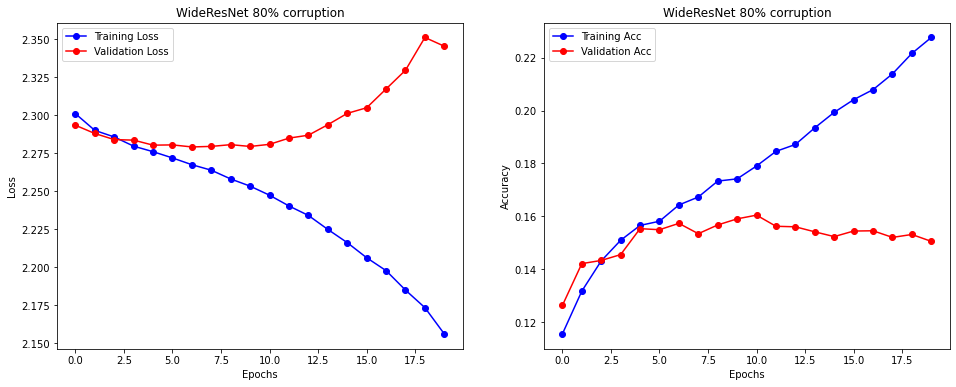

In [35]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "WideResNet 80% corruption")

In [36]:
model = WideResNet()
sd = torch.load("WideResNet_corr_80.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.1605
Confusion Matrix:
 [[218  75  69  58  39 140  74  75 138 125]
 [129 178  63  61  27 132  91  58 127 163]
 [135  74 101  75  38 170  92  67 124 111]
 [121  80  55 107  40 219  98  73 111 116]
 [117  71  98  63  50 161 118  79 101  96]
 [128  81  78  73  24 222  69  87 111 108]
 [109  89  78  67  49 141 188  78  95 121]
 [139  96  56  72  37 164  99 113 111 111]
 [134  91  55  69  31 135  97  61 207 107]
 [120 106  57  55  26 151  77  73 132 221]]


In [37]:
final_dict[80] = {}
final_dict[80]["train_losses"] = train_losses
final_dict[80]["valid_losses"] = valid_losses
final_dict[80]["train_accs"] = train_accs
final_dict[80]["validation_accs"] = validation_accs
final_dict[80]["best_test_acc"]  = accuracy_score(testy, pred)


In [38]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(1.0)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [39]:
model = WideResNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [40]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 20, train_loader, test_loader,
                                          device, criterion, optimizer, "WideResNet_corr_100")

Batch 0 Loss: 2.4559898376464844
Batch 200 Loss: 2.303041934967041
Batch 400 Loss: 2.321556568145752
Batch 600 Loss: 2.3175859451293945
Batch 800 Loss: 2.301528215408325
Batch 1000 Loss: 2.3041374683380127
Batch 1200 Loss: 2.2943687438964844
Batch 1400 Loss: 2.337761163711548
[Epoch 0] Train Loss: 2.3145126540374754 Vaidation Loss: 2.3130436977386473 Train Acc: 0.09932 Validation Acc: 0.0982
Batch 0 Loss: 2.3163461685180664
Batch 200 Loss: 2.330150604248047
Batch 400 Loss: 2.302412271499634
Batch 600 Loss: 2.312183380126953
Batch 800 Loss: 2.3227272033691406
Batch 1000 Loss: 2.2947380542755127
Batch 1200 Loss: 2.314922571182251
Batch 1400 Loss: 2.3032264709472656
[Epoch 1] Train Loss: 2.306743617706299 Vaidation Loss: 2.307341386795044 Train Acc: 0.10022 Validation Acc: 0.1001
Batch 0 Loss: 2.2769389152526855
Batch 200 Loss: 2.317674160003662
Batch 400 Loss: 2.2947328090667725
Batch 600 Loss: 2.2707841396331787
Batch 800 Loss: 2.2996816635131836
Batch 1000 Loss: 2.286806344985962
Batch

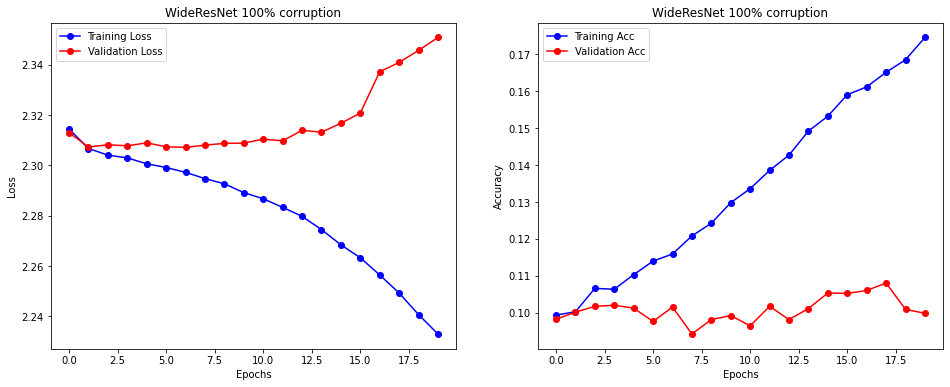

In [41]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "WideResNet 100% corruption")

In [42]:
model = WideResNet()
sd = torch.load("WideResNet_corr_100.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.108
Confusion Matrix:
 [[ 77  84  83 313  36  72 193  74  55  27]
 [ 54  91  62 361  30  56 216  85  62  23]
 [ 70  93  63 344  39  63 164  76  55  24]
 [ 60  91  68 394  41  64 158  77  44  15]
 [ 73  88  71 316  30  54 164  75  49  25]
 [ 64  94  69 340  38  74 176  79  53  30]
 [ 69  86  56 361  30  65 191  74  49  16]
 [ 74  85  75 351  36  62 148  88  50  24]
 [ 62  79  66 345  29  66 178  76  47  25]
 [ 65  82  61 358  31  77 181  80  58  25]]


In [43]:
final_dict[100] = {}
final_dict[100]["train_losses"] = train_losses
final_dict[100]["valid_losses"] = valid_losses
final_dict[100]["train_accs"] = train_accs
final_dict[100]["validation_accs"] = validation_accs
final_dict[100]["best_test_acc"]  = accuracy_score(testy, pred)


In [44]:
with open('final.pickle', 'wb') as f:
    pickle.dump(final_dict, f, protocol=pickle.HIGHEST_PROTOCOL)


In [45]:
!curl bashupload.com -T final.pickle

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Uploaded 1 file, 4 794 bytes

wget http://bashupload.com/10NRR/final.pickle


100  4926    0   132  100  4794    469  17060 --:--:-- --:--:-- --:--:-- 17530


In [46]:
!zip wideresnet.zip *.*
!curl bashupload.com -T wideresnet.zip

  adding: final.pickle (deflated 21%)
  adding: WideResNet_corr_0.pth (deflated 10%)
  adding: WideResNet_corr_100.pth (deflated 10%)
  adding: WideResNet_corr_20.pth (deflated 10%)
  adding: WideResNet_corr_40.pth (deflated 10%)
  adding: WideResNet_corr_60.pth (deflated 10%)
  adding: WideResNet_corr_80.pth (deflated 10%)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 63 8143k    0     0   63 5152k      0  5762k  0:00:01 --:--:--  0:00:01 5756k

Uploaded 1 file, 8 338 571 bytes

wget http://bashupload.com/kfuI6/wideresnet.zip


100 8143k    0   138  100 8143k    106  6307k  0:00:01  0:00:01 --:--:-- 6307k
